In [1]:
import overpy
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import cv2 

from shapely.geometry import Polygon
from shapely.ops import polygonize
from shapely.geometry import LineString

In [2]:
## Extracted all method calls to clean the looping method that makes overpass query and maps all regions.
## Try combinations of the list admin_levels in cell below to determine which combinations are best suited
## for the coverage of the city.

def create_dataFrame(overpass_query):
    # Collect the nodes into dataframe
    node_cols = ['id','lon','lat']
    df_nodes = pd.DataFrame([[getattr(node,a) for a in node_cols] for node in overpass_query.nodes])\
        .rename(columns=dict(zip(range(len(node_cols)),node_cols)))
    # Set the dataframe index to overpass node id column, drop the id column
    df_nodes = df_nodes.set_index(df_nodes.id)
    df_ways = pd.DataFrame(
    np.concatenate(
        [np.asarray([(w.id, n.id, w.tags) for n in w.nodes]) for w in overpass_query.ways]
    ))\
    .rename(columns={0:'way', 1:'node', 2:'tags'})
    df_ways = df_ways.set_index(df_ways.way)
    del df_nodes['id']
    del df_ways['way']
    return df_nodes, df_ways

def create_relation_dataFrame(overpass_query):
    # Collect the nodes into dataframe
    df_nodes, df_ways = create_dataFrame(overpass_query)
    df_relations = pd.DataFrame(np.concatenate(
        [np.asarray([(r.id, x.ref, r.tags, r.tags['name']) for x in r.members if isinstance(x, overpy.RelationWay)])\
         for r in overpass_query.relations]))\
        .rename(columns={0:'rel', 1:'way', 2:'tags', 3:'region'})

    # Assign dataframe index to column 'rel', drop the 'rel' column
    df_relations = df_relations.set_index(df_relations.rel)
    del df_relations['rel']
    return df_nodes, df_ways, df_relations

def draw_polys(image, nodes_array):
    lines = []
    for nodes in nodes_array:
        coords = city_nodes.loc[nodes].values
        coords = coords.astype(float)
        coords = coords - [[bbox[1], bbox[0]]]
        coords = coords / [[bbox[3] - bbox[1], bbox[2] - bbox[0]]]
        coords = coords * [[width, height]]
        coords = coords.astype(int)
        lines.append(LineString(coords))
        
    polys = polygonize(lines)
    polygons = len(list(polygonize(lines))) + 1
    print(f"No of polygons: {polygons}")
    for index, poly in enumerate(polys):
        color = (255 / polygons) * (index + 1)
        cv2.fillPoly(image, pts = [np.array(poly.exterior.coords).astype(int)], color = color)
        

In [11]:
## Place appropriate Co-ordinates here to get the region areas.
## Also try the admin_levels in overpass query used by the specific regions or countries use for mapping in link below
## https://wiki.openstreetmap.org/wiki/Tag:boundary%3Dadministrative#11_admin_level_values_for_specific_countries
## E.g. Barcelona region has outskirts of the city included too, which require admin_level 10 and 9 together 
## whereas Moscow covers the city, and maps well with admin_level 8. play around with this to get better region informations
## and maybe group these together for good coverage.

# Barcelona   

# MIN_LAT = 41.2313
# MIN_LONG = 1.8732
# MAX_LAT = 41.6709
# MAX_LONG = 2.3950


# Moscow   

MIN_LAT = 55.5651
MIN_LONG = 37.3535
MAX_LAT = 55.9184
MAX_LONG = 37.8630

admin_levels = [8, 10]

cv2_height, cv2_width = 3000, 3000

box = np.array([[MIN_LAT, MIN_LONG], [MAX_LAT, MAX_LONG]])

image_height, image_width = 495, 436 # Output width in pixels

city_relations, city_ways, city_nodes = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for index, admin_level in enumerate(admin_levels):
    bbox = (MIN_LAT, MIN_LONG, MAX_LAT, MAX_LONG)

    overpass_api = overpy.Overpass()
    result = overpass_api.query(f'''
    (
      way["admin_level"="{admin_level}"]{bbox};
      relation["admin_level"="{admin_level}"]{bbox};
    );
    (._;>;);
    out;
    ''' )
    if result.nodes:
        df_nodes, df_ways, df_relations = create_relation_dataFrame(result)

        city_nodes = city_nodes.append(df_nodes)
        city_ways = city_ways.append(df_ways)
        city_relations = city_relations.append(df_relations)

        print(city_nodes.shape, city_ways.shape, city_relations.shape)
city_relations

(19071, 2) (21011, 2) (3453, 3)


,way,tags,region
rel,,,
226927,206543634,"{'addr:country': 'RU', 'addr:region': 'Москва'...",район Кунцево
226927,206543632,"{'addr:country': 'RU', 'addr:region': 'Москва'...",район Кунцево
226927,206530336,"{'addr:country': 'RU', 'addr:region': 'Москва'...",район Кунцево
226927,206530309,"{'addr:country': 'RU', 'addr:region': 'Москва'...",район Кунцево
226927,206530305,"{'addr:country': 'RU', 'addr:region': 'Москва'...",район Кунцево
...,...,...,...
2162195,179982153,"{'admin_level': '8', 'alt_name': 'муниципальны...",Басманный район
2162195,449099012,"{'admin_level': '8', 'alt_name': 'муниципальны...",Басманный район
2162195,84039112,"{'admin_level': '8', 'alt_name': 'муниципальны...",Басманный район


In [12]:
city_relations.to_csv("moscow_admin_lvl_8_to_10.csv")
#city_relations.to_csv("barcelona_admin_lvl_8_to_10.csv")

No of polygons: 53


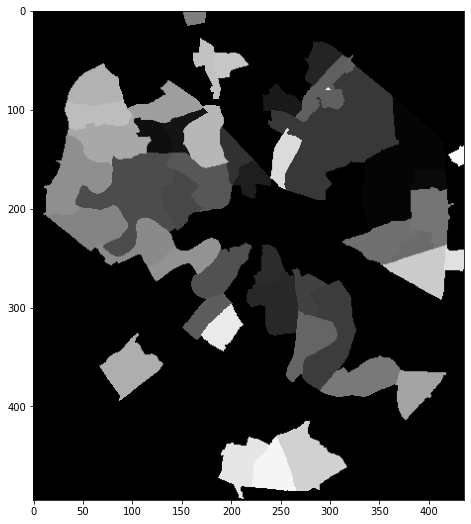

In [13]:

# boundaries
boundaries_rel = city_relations[city_relations.apply(lambda x: 'boundary' in x['tags'], axis=1)]['way']
boundaries_relation_ways = city_ways[city_ways.index.isin(boundaries_rel)]
boundaries_ways = city_ways[city_ways.apply(lambda x: 'boundaries' in x['tags'], axis=1)]
boundaries_ways = pd.concat([boundaries_relation_ways])
boundaries = boundaries_ways.groupby(['way']).node.apply(list)


color_land = 0
        
width, height = image_width, image_height
image = np.full((height,width,1), color_land, np.uint8)

draw_polys(image, boundaries)
image = cv2.flip(image, 0)
display_width, display_height = 12, 9
plt.figure(figsize=(display_width, display_height))
plt.imshow(image, cmap="gray")
plt.show()

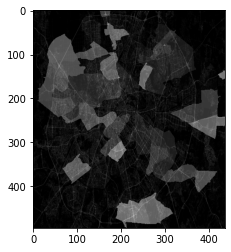

In [14]:
BASE_FOLDER = './raw'
city = 'MOSCOW'
from utils.h5utils import load_h5_file, write_data_to_h5

static_map = load_h5_file(f"{BASE_FOLDER}/{city}/{city}_static.h5")
static_map_mask = static_map[0]
plt.imshow(static_map_mask[0:495, 0:436], cmap="gray", vmin=0, vmax=255)
plt.imshow(image, cmap="gray", alpha=0.5, vmin=0, vmax=255)
plt.show()

In [15]:
static_map.shape, image.shape

((9, 495, 436), (495, 436))

In [16]:
static_map_w_clusters = np.append(static_map, [image], axis=0)
static_map_w_clusters.shape

(10, 495, 436)

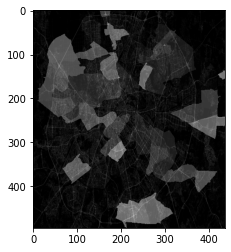

In [17]:
plt.imshow(static_map_mask[0:495, 0:436], cmap="gray", vmin=0, vmax=255)
plt.imshow(static_map_w_clusters[-1][0:495, 0:436], cmap="gray", vmin=0, vmax=255, alpha=0.5)

In [18]:
from pathlib import Path 
new_filename = f"{BASE_FOLDER}/{city}/{city}_static_with_region_layer"
new_filename_w_ext = Path(new_filename).with_suffix('.h5')
print(f"Saving file to: {new_filename_w_ext}")
write_data_to_h5(static_map_w_clusters, new_filename_w_ext)

Saving file to: raw/MOSCOW/MOSCOW_static_with_region_layer.h5
